In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import ensemble, metrics
from sklearn.metrics import mean_squared_error
pd.options.display.float_format = '{:,.3f}'.format

### **LOAD FILES**

In [2]:
parser = lambda date: pd.to_datetime(date, format='%d.%m.%Y')

train = pd.read_csv('sales_train.csv', parse_dates=['date'], date_parser=parser)
test = pd.read_csv('test.csv')
items = pd.read_csv('items.csv')
item_cats = pd.read_csv('item_categories.csv')
shops = pd.read_csv('shops.csv')

print('train:', train.shape, 'test:', test.shape)
print('items:', items.shape, 'item_cats:', item_cats.shape, 'shops:', shops.shape)

train: (2935849, 6) test: (214200, 3)
items: (22170, 3) item_cats: (84, 2) shops: (60, 2)


In [3]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.000,1.000
1,2013-01-03,0,25,2552,899.000,1.000
2,2013-01-05,0,25,2552,899.000,-1.000
3,2013-01-06,0,25,2554,"1,709.050",1.000
4,2013-01-15,0,25,2555,"1,099.000",1.000


In [4]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [5]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [6]:
item_cats.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [7]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


### **Data Analysis**

In [8]:
# There are 60 shops, 34 months worth of data given
# There are 84 item_categories
# There are 22170 unique items or (item_id)s
# Sales_train.csv or train data has daily transactions with item_cnt_day
# We have to predict monthly sales for a particular item_id in a particular shop or (shop_id) using the test file

In [9]:
# To find those shops or items that are in test set but not in train set

items_test_only = test[~test['item_id'].isin(train['item_id'].unique())]['item_id'].unique()
print('test only items:', len(items_test_only))

shops_test_only = test[~test['shop_id'].isin(train['shop_id'].unique())]['shop_id'].unique()
print('test only shops:', len(shops_test_only))

# Thus there are 363 items that are there in the test data but not there in the train data
# No such shops that are in the test but not in the train data

test only items: 363
test only shops: 0


## **Create database which has monthly shop and item combination**

In [10]:
train_grp = train.groupby(['date_block_num','shop_id','item_id'])
train_grp.mean()

item_price  item_cnt_day
date_block_num shop_id item_id                          
0              0       32          221.000         1.500
                       33          347.000         1.000
                       35          247.000         1.000
                       43          221.000         1.000
                       51          128.500         1.000
...                                    ...           ...
33             59      22087       119.000         2.000
                       22088       119.000         1.000
                       22091       179.000         1.000
                       22100       629.000         1.000
                       22102     1,250.000         1.000

[1609124 rows x 2 columns]

### **Aggregate Grouped Data**

In [11]:
# summary count by month
train_monthly = pd.DataFrame(train_grp.agg({'item_cnt_day':'sum'})).reset_index()
train_monthly.columns = ['date_block_num','shop_id','item_id','item_cnt']
print(train_monthly[['item_cnt']].describe())

# Remove anomalies in dataset
train_monthly['item_cnt'].clip(0, 20, inplace=True)

train_monthly

           item_cnt
count 1,609,124.000
mean          2.267
std           8.650
min         -22.000
25%           1.000
50%           1.000
75%           2.000
max       2,253.000


,date_block_num,shop_id,item_id,item_cnt
0,0,0,32,6.000
1,0,0,33,3.000
2,0,0,35,1.000
3,0,0,43,1.000
4,0,0,51,2.000
...,...,...,...,...
1609119,33,59,22087,6.000
1609120,33,59,22088,2.000
1609121,33,59,22091,1.000
1609122,33,59,22100,1.000


## **Generating Feature sets**

In [12]:
# pickup first category name
item_grp = item_cats['item_category_name'].apply(lambda x: str(x).split(' ')[0])
item_cats['item_group'] = pd.Categorical(item_grp).codes
#item_cats = item_cats.join(pd.get_dummies(item_grp, prefix='item_group', drop_first=True))
items = pd.merge(items, item_cats.loc[:,['item_category_id','item_group']], on=['item_category_id'], how='left')

items

,item_name,item_id,item_category_id,item_group
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,7
1,!ABBYY FineReader 12 Professional Edition Full...,1,76,11
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,7
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,7
4,***КОРОБКА (СТЕКЛО) D,4,40,7
...,...,...,...,...
22165,"Ядерный титбит 2 [PC, Цифровая версия]",22165,31,5
22166,Язык запросов 1С:Предприятия [Цифровая версия],22166,54,8
22167,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,22167,49,8
22168,Яйцо для Little Inu,22168,62,10


In [13]:
city = shops.shop_name.apply(lambda x: str.replace(x, '!', '')).apply(lambda x: x.split(' ')[0])
shops['city'] = pd.Categorical(city).codes

shops

,shop_name,shop_id,city
0,"!Якутск Орджоникидзе, 56 фран",0,29
1,"!Якутск ТЦ ""Центральный"" фран",1,29
2,"Адыгея ТЦ ""Мега""",2,0
3,"Балашиха ТРК ""Октябрь-Киномир""",3,1
4,"Волжский ТЦ ""Волга Молл""",4,2
5,"Вологда ТРЦ ""Мармелад""",5,3
6,"Воронеж (Плехановская, 13)",6,4
7,"Воронеж ТРЦ ""Максимир""",7,4
8,"Воронеж ТРЦ Сити-Парк ""Град""",8,4
9,Выездная Торговля,9,5


In [14]:
# By shop,item
grp = train_monthly.groupby(['shop_id', 'item_id'])
train_shop = grp.agg({'item_cnt':'mean'}).reset_index()
train_shop.columns = ['shop_id','item_id','cnt_mean_shop']
train_shop

,shop_id,item_id,cnt_mean_shop
0,0,30,20.000
1,0,31,11.000
2,0,32,8.000
3,0,33,3.000
4,0,35,7.500
...,...,...,...
424119,59,22154,1.000
424120,59,22155,1.000
424121,59,22162,3.200
424122,59,22164,1.500


In [15]:
## By shop,item_group
train_cat_monthly = pd.merge(train_monthly, items, on=['item_id'], how='left')
grp = train_cat_monthly.groupby(['shop_id', 'item_group'])
train_shop_cat = grp.agg({'item_cnt':['mean']}).reset_index()
train_shop_cat.columns = ['shop_id','item_group','cnt_mean_shop_cat']
print(train_shop_cat.loc[:,['cnt_mean_shop_cat']].describe())

train_shop_cat

       cnt_mean_shop_cat
count            700.000
mean               3.307
std                3.059
min                0.980
25%                1.502
50%                2.042
75%                3.379
max               20.000


,shop_id,item_group,cnt_mean_shop_cat
0,0,0,1.000
1,0,1,4.010
2,0,4,3.088
3,0,5,3.774
4,0,6,2.846
...,...,...,...
695,59,9,1.246
696,59,10,1.661
697,59,11,2.235
698,59,12,12.833


#### **Item Prices**

In [16]:
# Price mean by month,shop,item
train_price = train_grp['item_price'].mean().reset_index()
price = train_price[~train_price['item_price'].isnull()]

# last price by shop,item
last_price = price.drop_duplicates(subset=['shop_id', 'item_id'], keep='last').drop(['date_block_num'], axis=1)


In [17]:
pred_price_set = test.copy()
pred_price_set.drop('ID', axis=1)

,shop_id,item_id
0,5,5037
1,5,5320
2,5,5233
3,5,5232
4,5,5268
...,...,...
214195,45,18454
214196,45,16188
214197,45,15757
214198,45,19648


In [18]:
reg = ensemble.ExtraTreesRegressor(n_estimators=25, n_jobs=-1, max_depth=15, random_state=42)
reg.fit(last_price[['shop_id','item_id']], last_price['item_price'])
pred_price_set['item_price'] = reg.predict(pred_price_set[['shop_id','item_id']])

test_price = pd.concat([last_price, pred_price_set], join='inner')
pred_price_set.drop(['ID'], axis=1, inplace=True)
pred_price_set

,shop_id,item_id,item_price
0,5,5037,"1,242.684"
1,5,5320,758.090
2,5,5233,"1,018.521"
3,5,5232,977.938
4,5,5268,912.563
...,...,...,...
214195,45,18454,175.783
214196,45,16188,906.817
214197,45,15757,325.650
214198,45,19648,320.414


In [19]:
test_price

,shop_id,item_id,item_price
3,0,43,221.000
5,0,61,195.000
6,0,75,76.000
7,0,88,76.000
8,0,95,193.000
...,...,...,...
214195,45,18454,175.783
214196,45,16188,906.817
214197,45,15757,325.650
214198,45,19648,320.414


#### **Discount Rates**

In [20]:
# Since the same item is available in different shops at different prices
# It makes sense to know around how much discount is present

price_max = price.groupby(['item_id']).max()['item_price'].reset_index()
price_max.rename(columns={'item_price':'item_max_price'}, inplace=True)
price_max.head()

,item_id,item_max_price
0,0,58.000
1,1,"4,490.000"
2,2,58.000
3,3,100.000
4,4,58.000


In [21]:
train_price_disc = pd.merge(price, price_max, on=['item_id'], how='left')
train_price_disc['discount_rate'] = 1 - (train_price_disc['item_price'] / train_price_disc['item_max_price'])
train_price_disc.drop('item_max_price', axis=1, inplace=True)
train_price_disc

,date_block_num,shop_id,item_id,item_price,discount_rate
0,0,0,32,221.000,0.367
1,0,0,33,347.000,0.305
2,0,0,35,247.000,0.381
3,0,0,43,221.000,0.109
4,0,0,51,128.500,0.570
...,...,...,...,...,...
1609119,33,59,22087,119.000,0.000
1609120,33,59,22088,119.000,0.000
1609121,33,59,22091,179.000,0.000
1609122,33,59,22100,629.000,0.000


In [22]:
test_price_disc = pd.merge(pred_price_set, price_max, on=['item_id'], how='left')
test_price_disc.loc[test_price_disc['item_max_price'].isnull(), 'item_max_price'] = test_price_disc['item_price']
test_price_disc['discount_rate'] = 1 - (test_price_disc['item_price'] / test_price_disc['item_max_price'])
test_price_disc.drop('item_max_price', axis=1, inplace=True)
test_price_disc

,shop_id,item_id,item_price,discount_rate
0,5,5037,"1,242.684",0.522
1,5,5320,758.090,0.000
2,5,5233,"1,018.521",0.151
3,5,5232,977.938,0.184
4,5,5268,912.563,0.000
...,...,...,...,...
214195,45,18454,175.783,0.117
214196,45,16188,906.817,0.333
214197,45,15757,325.650,-0.422
214198,45,19648,320.414,-2.237


## Data train & test preparation

In [23]:
def mergeFeature(df): 
  df = pd.merge(df, items, on=['item_id'], how='left').drop('item_group', axis=1)
  df = pd.merge(df, item_cats, on=['item_category_id'], how='left')
  df = pd.merge(df, shops, on=['shop_id'], how='left')

  df = pd.merge(df, train_shop, on=['shop_id','item_id'], how='left')
  df = pd.merge(df, train_shop_cat, on=['shop_id','item_group'], how='left')
  
  df.drop(['shop_name','item_name','item_category_name','item_group'], axis=1, inplace=True)
  df.fillna(0.0, inplace=True)
  return df

In [24]:
train_set = train_monthly[train_monthly['date_block_num'] >= 10]

train_set = pd.merge(train_set, train_price_disc, on=['date_block_num','shop_id','item_id'], how='left')
train_set = mergeFeature(train_set)

X_train = train_set.drop(['item_cnt'], axis=1)
Y_train = train_set['item_cnt']
print(Y_train)
# X_train.loc[X_train['discount_rate'].isnull()]
X_train

0         2.000
1         1.000
2         2.000
3         1.000
4         1.000
           ... 
1039131   6.000
1039132   2.000
1039133   1.000
1039134   1.000
1039135   1.000
Name: item_cnt, Length: 1039136, dtype: float64


,date_block_num,shop_id,item_id,item_price,discount_rate,item_category_id,city,cnt_mean_shop,cnt_mean_shop_cat
0,10,2,33,199.000,0.601,37,0,1.100,1.217
1,10,2,97,149.000,0.000,40,0,1.000,1.217
2,10,2,482,"3,300.000",0.000,73,0,1.400,1.688
3,10,2,791,600.000,0.000,73,0,1.667,1.688
4,10,2,944,299.000,0.455,37,0,1.000,1.217
...,...,...,...,...,...,...,...,...,...
1039131,33,59,22087,119.000,0.000,83,30,6.424,5.028
1039132,33,59,22088,119.000,0.000,83,30,6.156,5.028
1039133,33,59,22091,179.000,0.000,83,30,2.294,5.028
1039134,33,59,22100,629.000,0.000,42,30,1.000,1.097


In [25]:
test_set = test.copy()
test_set['date_block_num'] = 34

test_set = pd.merge(test_set, test_price_disc, on=['shop_id','item_id'], how='left')
test_set = mergeFeature(test_set)

price_mean = X_train['item_price'].mean()
discount_mean = X_train['discount_rate'].mean()
print(price_mean)
X_test = test_set.drop(['ID'], axis=1)
# X_test['item_price'].fillna(price_mean, inplace=True)
# X_test['discount_rate'].fillna(discount_mean, inplace=True)
assert(X_train.columns.isin(X_test.columns).all())
X_test

874.3922656060104


,shop_id,item_id,date_block_num,item_price,discount_rate,item_category_id,city,cnt_mean_shop,cnt_mean_shop_cat
0,5,5037,34,"1,242.684",0.522,19,3,1.444,2.163
1,5,5320,34,758.090,0.000,55,3,0.000,1.246
2,5,5233,34,"1,018.521",0.151,19,3,2.000,2.163
3,5,5232,34,977.938,0.184,23,3,1.000,2.163
4,5,5268,34,912.563,0.000,20,3,0.000,2.163
...,...,...,...,...,...,...,...,...,...
214195,45,18454,34,175.783,0.117,55,20,1.800,1.270
214196,45,16188,34,906.817,0.333,64,20,0.000,1.626
214197,45,15757,34,325.650,-0.422,55,20,1.167,1.270
214198,45,19648,34,320.414,-2.237,40,20,0.000,1.387


## Linear Regression

In [26]:
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline

In [27]:
regressor = LinearRegression()  
regressor.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [28]:
coeff_df = pd.DataFrame(regressor.coef_, X_train.columns, columns=['Coefficient'])  
coeff_df

,Coefficient
date_block_num,-0.029
shop_id,-0.002
item_id,0.000
item_price,0.000
discount_rate,-0.233
item_category_id,0.002
city,0.003
cnt_mean_shop,0.941
cnt_mean_shop_cat,0.038


In [29]:
y_linear_pred = regressor.predict(X_test)
y_linear_pred

array([ -6.90556073,  -8.58842261,  -6.63644875, ..., -26.33977855,
       -33.69567165,  -0.80029294])

In [30]:
rmse_linear = np.sqrt(mean_squared_error(Y_train, regressor.predict(X_train)))
print('RFR RMSE: %.4f' % rmse_linear)

RFR RMSE: 1.8683


## Ridge Regression

In [31]:
from sklearn.datasets import make_regression
from matplotlib import pyplot as plt
from sklearn.linear_model import Ridge

In [32]:
rr100 = Ridge(alpha=100) 
rr100.fit(X_train, Y_train)

Ridge(alpha=100, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [33]:
w = rr100.coef_
w

array([-2.88375541e-02, -1.70882143e-03,  1.19852582e-06,  2.11482235e-05,
       -2.32094396e-01,  2.30756811e-03,  3.12881244e-03,  9.40473425e-01,
        3.79637708e-02])

In [34]:
y_ridge_pred = rr100.predict(X_test)
y_ridge_pred

array([ -6.90384412,  -8.58676155,  -6.63484356, ..., -26.33508069,
       -33.69050358,  -0.79995127])

In [35]:
rmse_rr = np.sqrt(mean_squared_error(Y_train, rr100.predict(X_train)))
print('RFR RMSE: %.4f' % rmse_rr)

RFR RMSE: 1.8683


## Lasso Regression

In [36]:
from sklearn.linear_model import Lasso

In [37]:
lasso = Lasso(alpha=0.01, max_iter=10e5)
lasso.fit(X_train,Y_train)

y_lasso_pred = lasso.predict(X_test)
y_lasso_pred

array([ 0.83685308, -0.48258286,  1.33322003, ..., -2.43295298,
       -4.20953592,  0.65714701])

In [38]:
rmse_lr = np.sqrt(mean_squared_error(Y_train, lasso.predict(X_train)))
print('RFR RMSE: %.4f' % rmse_lr)

RFR RMSE: 1.8688


## Support vector regression(takes too long)

In [39]:
# from sklearn.svm import SVR
# SVregressor = SVR(kernel = 'rbf')
# SVregressor.fit(X_linear_train, y_linear_train)

In [40]:
# y_pred = SVregressor.predict(X_linear_test)

# df = pd.DataFrame({'Actual': y_linear_test, 'Predicted': y_pred})
# df.head(25)

In [41]:
# print('Mean Absolute Error:', metrics.mean_absolute_error(y_linear_test, y_pred))  
# print('Mean Squared Error:', metrics.mean_squared_error(y_linear_test, y_pred))  
# print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_linear_test, y_pred)))

## GroupKfold

In [42]:
X_train

,date_block_num,shop_id,item_id,item_price,discount_rate,item_category_id,city,cnt_mean_shop,cnt_mean_shop_cat
0,10,2,33,199.000,0.601,37,0,1.100,1.217
1,10,2,97,149.000,0.000,40,0,1.000,1.217
2,10,2,482,"3,300.000",0.000,73,0,1.400,1.688
3,10,2,791,600.000,0.000,73,0,1.667,1.688
4,10,2,944,299.000,0.455,37,0,1.000,1.217
...,...,...,...,...,...,...,...,...,...
1039131,33,59,22087,119.000,0.000,83,30,6.424,5.028
1039132,33,59,22088,119.000,0.000,83,30,6.156,5.028
1039133,33,59,22091,179.000,0.000,83,30,2.294,5.028
1039134,33,59,22100,629.000,0.000,42,30,1.000,1.097


In [43]:
X_test

,shop_id,item_id,date_block_num,item_price,discount_rate,item_category_id,city,cnt_mean_shop,cnt_mean_shop_cat
0,5,5037,34,"1,242.684",0.522,19,3,1.444,2.163
1,5,5320,34,758.090,0.000,55,3,0.000,1.246
2,5,5233,34,"1,018.521",0.151,19,3,2.000,2.163
3,5,5232,34,977.938,0.184,23,3,1.000,2.163
4,5,5268,34,912.563,0.000,20,3,0.000,2.163
...,...,...,...,...,...,...,...,...,...
214195,45,18454,34,175.783,0.117,55,20,1.800,1.270
214196,45,16188,34,906.817,0.333,64,20,0.000,1.626
214197,45,15757,34,325.650,-0.422,55,20,1.167,1.270
214198,45,19648,34,320.414,-2.237,40,20,0.000,1.387


In [44]:
from sklearn import linear_model, preprocessing
from sklearn.model_selection import GroupKFold
import lightgbm as lgb

params={'learning_rate': 0.05,
        'objective':'regression',
        'metric':'rmse',
        'num_leaves': 64,
        'verbose': 1,
        'random_state':42,
        'bagging_fraction': 1,
        'feature_fraction': 1
       }

folds = GroupKFold(n_splits=6)
oof_preds = np.zeros(X_train.shape[0])
sub_preds = np.zeros(X_test.shape[0])

for fold_, (trn_, val_) in enumerate(folds.split(X_train, Y_train, X_train['date_block_num'])):
    trn_x, trn_y = X_train.iloc[trn_], Y_train[trn_]
    val_x, val_y = X_train.iloc[val_], Y_train[val_]

    reg = lgb.LGBMRegressor(**params, n_estimators=3000)
    reg.fit(trn_x, trn_y, eval_set=[(val_x, val_y)], early_stopping_rounds=50, verbose=500)
    
    oof_preds[val_] = reg.predict(val_x.values, num_iteration=reg.best_iteration_)
    sub_preds += reg.predict(X_test.values, num_iteration=reg.best_iteration_) / folds.n_splits

Training until validation scores don't improve for 50 rounds
[500]	valid_0's rmse: 1.82598
Early stopping, best iteration is:
[507]	valid_0's rmse: 1.82561
Training until validation scores don't improve for 50 rounds
[500]	valid_0's rmse: 1.72164
Early stopping, best iteration is:
[454]	valid_0's rmse: 1.72077
Training until validation scores don't improve for 50 rounds
[500]	valid_0's rmse: 1.56697
Early stopping, best iteration is:
[467]	valid_0's rmse: 1.56633
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[214]	valid_0's rmse: 1.75462
Training until validation scores don't improve for 50 rounds
[500]	valid_0's rmse: 1.56878
Early stopping, best iteration is:
[931]	valid_0's rmse: 1.54938
Training until validation scores don't improve for 50 rounds
[500]	valid_0's rmse: 1.73123
Early stopping, best iteration is:
[480]	valid_0's rmse: 1.73093


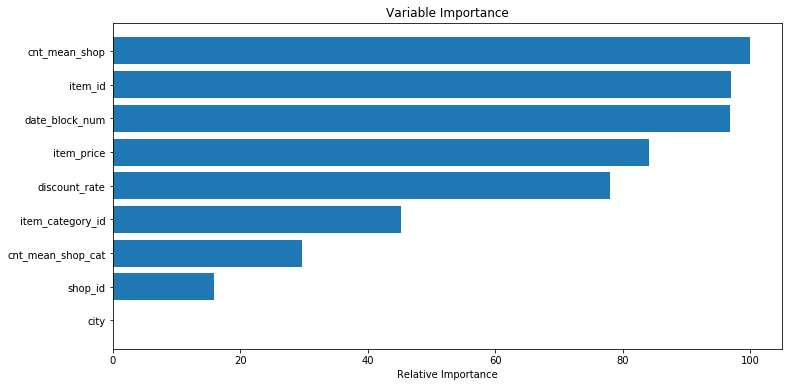

In [45]:
pred_cnt = sub_preds

# Plot feature importance
feature_importance = reg.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(12,6))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [46]:
result = pd.DataFrame({
    "ID": test["ID"],
    "item_cnt_month": sub_preds
})
result.to_csv("submissionk.csv", index=False)
result.head(30)

,ID,item_cnt_month
0,0,1.489
1,1,0.387
2,2,2.300
3,3,1.178
4,4,0.465
5,5,1.932
6,6,3.107
7,7,2.097
8,8,6.649
9,9,0.614
